In [ ]:
# %%

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class QNet(nn.Module):
    def __init__(self, obs_size, n_actions):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(obs_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, n_actions)

    def forward(self, state):
        # ====================================================
        
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        Q = self.fc3(x) ### We output Q values no need for sigmoid or relu 
        
        # ====================================================
        return Q

    def select_greedyaction(self, state):
        with torch.no_grad():
            # ====================================================
            Q = self.forward(state)
            action_index = torch.argmax(Q,1)
            
            # ====================================================
        return action_index.item()


class DQNet(nn.Module):

      def __init__(self, obs_size, n_actions):
        super(DQNet, self).__init__()
        self.fc1 = nn.Linear(obs_size, 64)
        self.relu = nn.ReLU()

        self.fc2_A = nn.Linear(64, 256)
        self.fc3_A = nn.Linear(256, n_actions)
        
        self.fc2_V = nn.Linear(64, 256)
        self.fc3_V = nn.Linear(256, 1)
        

      def forward(self, state):
        # ====================================================
        
        x = self.relu(self.fc1(state))

        x_A = self.relu(self.fc2_A(x))
        A = self.fc3_A(x_A)

        x_V = self.relu(self.fc2_V(x))
        V = self.fc3_V((x_V))

        Q = V + A - torch.mean(A,dim=1).unsqueeze(1)

        return Q
        
        

      def select_greedyaction(self, state):

        with torch.no_grad():
            # ====================================================
            Q = self.forward(state)
            action_index = torch.argmax(Q,1)
            
            # ====================================================
        return action_index.item()


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, sample):
        """Saves a transition.
            sample is a tuple (state, next_state, action, reward, done)
        """
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = sample
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch_size = min(len(self.memory), batch_size)
        samples = random.sample(self.memory, batch_size)
        return map(np.asarray, zip(*samples))

    def __len__(self):
        return len(self.memory)

def eval_dqn(env, qnet, n_sim=5):
    """
    Monte Carlo evaluation of DQN agent
    """
    rewards = np.zeros(n_sim)
    copy_env = deepcopy(env) # Important!
    # Loop over number of simulations
    for sim in range(n_sim):
        state = copy_env.reset()
        done = False
        while not done:
            tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = qnet.select_greedyaction(tensor_state)
            next_state, reward, done, _ = copy_env.step(action)
            # update sum of rewards
            rewards[sim] += reward
            state = next_state
    return rewards

# Discount factor
GAMMA = 0.99
EVAL_EVERY = 2

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 30000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
#N_EPISODES = 250

# Learning rate
LEARNING_RATE = 0.1

def one_experiment(N_EPISODES=100,duelling=False,double=False):
    
    env = gym.make('CartPole-v0')


    # initialize replay buffer
    replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

    # create network and target network
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n
    # ====================================================
    # YOUR IMPLEMENTATION HERE 
    # Define networks

    if duelling :

      q_net  = DQNet(obs_size,n_actions).to(device)
      target_net  = DQNet(obs_size,n_actions).to(device)

    else :

      q_net  = QNet(obs_size,n_actions).to(device)
      target_net  = QNet(obs_size,n_actions).to(device)


    target_net.load_state_dict(q_net.state_dict())

    # ====================================================

    # objective and optimizer
    optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)
    MSE_loss = nn.MSELoss()

    # Algorithm
    state = env.reset()
    epsilon = EPSILON_START
    ep = 0
    total_time = 0
    learn_steps = 0
    episode_reward = 0

    episode_rewards = np.zeros((N_EPISODES, 3))
    while ep < N_EPISODES:
        # ====================================================
        # YOUR IMPLEMENTATION HERE 
        # sample epsilon-greedy action
        #
        p = random.random()
        if p < epsilon:
            
            action = np.random.randint(0,n_actions)
            
            
        else:
            tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = q_net.select_greedyaction(tensor_state)
            
        # ====================================================
        
        
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        total_time += 1
        
        # ====================================================
        # YOUR IMPLEMENTATION HERE 
        # add sample to buffer
        #
        transition = (state,next_state,action,reward, done)
        replay_buffer.push(transition)

        # ====================================================


        if len(replay_buffer) > BATCH_SIZE:
            learn_steps += 1
            # UPDATE MODEL
            # ====================================================
            # YOUR IMPLEMENTATION HERE 
            # get batch
            batch_state, batch_next_state, batch_action, batch_reward, batch_done = replay_buffer.sample(BATCH_SIZE)
            # ====================================================


            batch_state = torch.FloatTensor(batch_state).to(device)
            batch_next_state = torch.FloatTensor(batch_next_state).to(device)
            batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
            batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
            batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

            with torch.no_grad():

                if double : 

                  # ====================================================              
                  
                  ## Double Q learning 
                  tgt_Q = target_net(batch_next_state)
                  real_Q = q_net(batch_next_state)

                  greedy_Q = torch.max(tgt_Q,dim=1)[0].unsqueeze(1)
                  greedy_A = torch.max(tgt_Q,dim=1)[1].unsqueeze(1)

                  unb_Q    =  real_Q.gather(1,greedy_A)                
                  targets =  batch_reward + GAMMA * (1-batch_done) * unb_Q
                  

                  # ====================================================

                else :

                  ### SIMPLE Q LEARNING
                  tgt_Q = target_net(batch_next_state)
                  greedy_Q = torch.max(tgt_Q,dim=1)[0].unsqueeze(1)
                  targets =  batch_reward + GAMMA * (1-batch_done) * greedy_Q

                  # ====================================================



            values = q_net(batch_state).gather(1, batch_action.long()).to(device)


            # ====================================================
            # YOUR IMPLEMENTATION HERE 
            # compute loss and update model (loss and optimizer)
            
            
            loss =MSE_loss(targets,values)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # ====================================================

            if epsilon > EPSILON_MIN:
                epsilon -= (EPSILON_START - EPSILON_MIN) / DECREASE_EPSILON
        


        # ====================================================
        # YOUR IMPLEMENTATION HERE 
        # update target network
        if learn_steps % UPDATE_TARGET_EVERY == 0:
            target_net.load_state_dict(q_net.state_dict())
        # ====================================================

        state = next_state

        if done:

          mean_rewards = -1
          if (ep+1) % EVAL_EVERY == 0:
              # evaluate current policy
              rewards = eval_dqn(env, q_net)
              mean_rewards = np.mean(rewards)

              #print("episode =", ep, ", reward = ", np.round(np.mean(rewards),2), ", obs_rew = ", episode_reward)

              # if np.mean(rewards) >= REWARD_THRESHOLD:
              #     break
          
          episode_rewards[ep] = [total_time, episode_reward, mean_rewards]
          state = env.reset()
          ep += 1
          episode_reward = 0
        
    print("Done with one trial")
    return episode_rewards


def full_experiment(double,duelling,N_TRIALS = 5,N_EPISODES = 150):

    save_path = 'DQN'+ duelling * '_DUELLING' + double * '_DOUBLE'+ '_REWARDS'

    all_rewards = np.zeros((N_TRIALS,N_EPISODES, 3))

    for i in range(N_TRIALS):
    
        all_rewards[i] = one_experiment(N_EPISODES=N_EPISODES,double=double,duelling=double)

    
    with open(save_path,'wb') as handle:

      pickle.dump(all_rewards,handle)
      


# %%


In [ ]:
##FALSE,FALSE
comb = [[False,False],[True,False],[False,True],[True,True]]

N_EPISODES = 100

N_TRIALS = 10

for exp in comb:

  full_experiment(*exp,N_TRIALS=N_TRIALS,N_EPISODES=N_EPISODES)

  print("Done with experiment",exp)

In [ ]:
def plot(reward_file,plot_train=True,plot_test=True,separate=True,N_TRIALS=N_TRIALS,N_EPISODES=N_EPISODES):



  with open(reward_file,'rb') as handle:
    all_rewards = pickle.load(handle)

  mean = np.mean(all_rewards,axis=0)
  std = np.std(all_rewards,axis=0)

  if plot_train:

    plt.figure()
    plt.title('Performance over learning')
    plt.plot(mean[:,0], mean[:,1],label=reward_file)
    plt.fill_between(mean[:,0], mean[:,1]-std[:,1],mean[:,1]+std[:,1],alpha=0.5)
    plt.xlabel('time steps')
    plt.ylabel('total reward')
    plt.legend()

  if plot_test:
    if separate :
      plt.figure()
      
    plt.title('Performance on Test Env')
    xv = np.arange(EVAL_EVERY-1, N_EPISODES+1, EVAL_EVERY)
    plt.plot(mean[xv,0],mean[xv,2],':o',label=reward_file)
    plt.fill_between(mean[xv, 0], mean[xv, 2]-std[xv, 2],mean[xv, 2]+std[xv, 2], ':o',alpha=0.3)
    plt.xlabel('time steps')
    plt.ylabel('expected total reward (greedy policy)')
    plt.legend()
    #plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


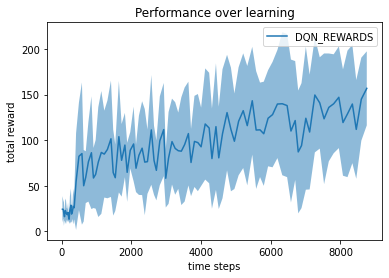

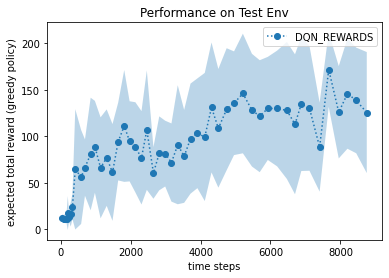

In [ ]:
plot("DQN_REWARDS")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


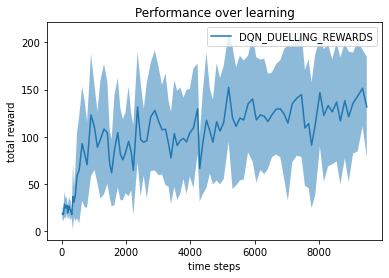

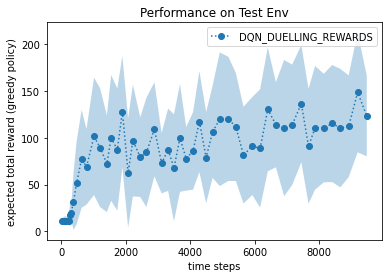

In [ ]:
plot("DQN_DUELLING_REWARDS")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


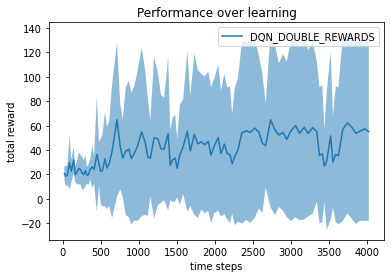

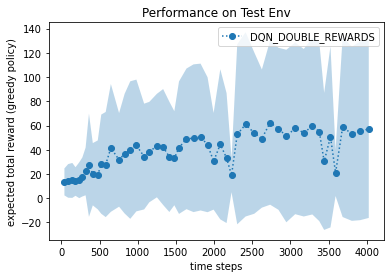

In [ ]:
plot("DQN_DOUBLE_REWARDS")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


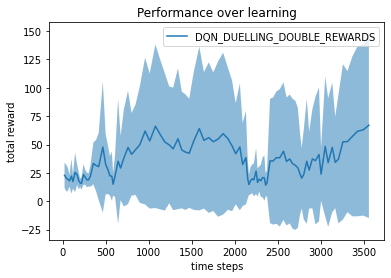

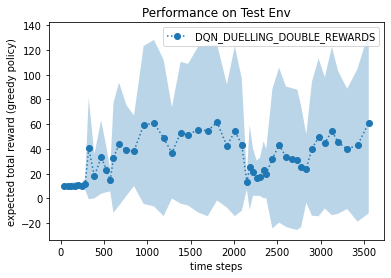

In [ ]:
plot("DQN_DUELLING_DOUBLE_REWARDS")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


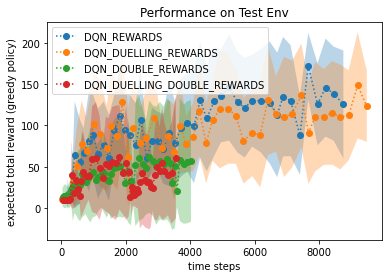

In [ ]:
for exp in comb :

  duelling = exp[0]
  double = exp[1]

  reward_path = 'DQN'+ duelling * '_DUELLING' + double * '_DOUBLE'+ '_REWARDS'

  plot(reward_path,plot_train=False,plot_test=True)

plt.show()

